In [96]:
import os, sys
import argparse
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math, re
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import sys
sys.path.append("..")

# user functions
from dataUtils import loadEnergyData, processData, energyDataset
from modelUtils import saveCheckpoint, loadCheckpoint, plotPredVsTrue, dotDict
from evaluation.denormalizedEval import denormalizeLoad


In [2]:
# last three months - test set
test_range = ["2014-10-01 00:00:00", "2014-12-31 23:00:00"]
test_range = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in test_range]# data directories
processed_dir = "../data/processed/"



In [5]:
energy_demand, adj_mat = loadEnergyData(processed_dir, incl_nodes = 'All', partial = False)
#bacis preprocessing and normalization
energy_demand = processData(energy_demand)

In [26]:
energy_demand

,time,node,hour,dow,month,year,holiday,season,country,voltage,solar_ecmwf,wind_ecmwf,load
0,2012-01-01 00:00:00,1,0,6,1,2012,1,3,20,380,0.0,0.0284,0.279887
1,2012-01-01 01:00:00,1,1,6,1,2012,1,3,20,380,0.0,0.0336,0.218439
2,2012-01-01 02:00:00,1,2,6,1,2012,1,3,20,380,0.0,0.0392,0.160968
3,2012-01-01 03:00:00,1,3,6,1,2012,1,3,20,380,0.0,0.0424,0.112879
4,2012-01-01 04:00:00,1,4,6,1,2012,1,3,20,380,0.0,0.0475,0.087529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39298171,2014-12-31 19:00:00,1514,19,2,12,2014,0,3,14,138,0.0,0.4647,0.523869
39298172,2014-12-31 20:00:00,1514,20,2,12,2014,0,3,14,138,0.0,0.5659,0.429327
39298173,2014-12-31 21:00:00,1514,21,2,12,2014,0,3,14,138,0.0,0.7116,0.343496
39298174,2014-12-31 22:00:00,1514,22,2,12,2014,0,3,14,138,0.0,0.7608,0.290838


In [77]:
energy_demand['time'] = pd.to_datetime(energy_demand['time'], format='%Y-%m-%d %H:%M:%S')
    
    # extract validation and training sets
#train_df = energy_demand[energy_demand['time'] < test_range[0]].reset_index(drop = True)
test_df = energy_demand[(energy_demand['time'] >= test_range[0]) & 
                           (energy_demand['time'] <= test_range[1])].reset_index(drop = True)

In [78]:
#train_df = train_df[['node','time','load']]
test_df = test_df[['node','time','load']]

In [24]:
test_df.time.unique().shape

(2208,)

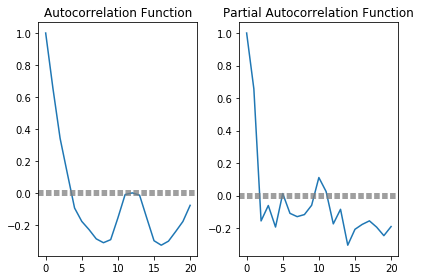

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


time
2014-10-27 00:00:00    0.218924
2014-10-27 01:00:00    0.177129
2014-10-27 02:00:00    0.149347
2014-10-27 03:00:00    0.134670
2014-10-27 04:00:00    0.107527
2014-10-27 05:00:00    0.135242
2014-10-27 06:00:00    0.166884
2014-10-27 07:00:00    0.199099
2014-10-27 08:00:00    0.327400
2014-10-27 09:00:00    0.450259
2014-10-27 10:00:00    0.493240
2014-10-27 11:00:00    0.519437
2014-10-27 12:00:00    0.544917
2014-10-27 13:00:00    0.490884
2014-10-27 14:00:00    0.514691
2014-10-27 15:00:00    0.530654
2014-10-27 16:00:00    0.549037
2014-10-27 17:00:00    0.562389
2014-10-27 18:00:00    0.610452
2014-10-27 19:00:00    0.659129
2014-10-27 20:00:00    0.637626
2014-10-27 21:00:00    0.551074
2014-10-27 22:00:00    0.484985
2014-10-27 23:00:00    0.401702
Name: load, dtype: float64


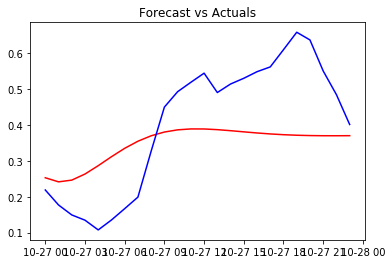

In [43]:
#time zone = 50, node =1
ts = train_df[train_df['node']==2]
ts.set_index('time', inplace=True)
ts = ts.load
sub_test = test_df[test_df['node']==2]
sub_test.set_index('time',inplace=True)
sub_test = sub_test.load
ts = pd.concat([ts,sub_test[0:12*52]])
#parameter d = 1
ts_diff=ts-ts.shift()
plt.plot(ts_diff)
ts_diff.dropna(inplace = True)
# find parameter p=2&q=4
lag_acf = acf(ts_diff,nlags=20)
lag_pacf = pacf(ts_diff,nlags = 20,method='ols')
#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')  # lowwer CI
plt.axhline(y=1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')  # upper CI
plt.title('Autocorrelation Function')
#plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()
      
#model
model = ARIMA(ts,order = (2,1,4))
model_fit = model.fit(disp=-1)
fc, se, conf = model_fit.forecast(24, alpha=0.05)
fc_series = pd.Series(fc, index=sub_test.index[12*52:12*52+24])
ARIMA_predicted_50_1=fc_series
#print(fc_series)
plt.plot(fc_series, label='forecast',color='red')
print(sub_test[12*52:12*52+24])
plt.plot(sub_test[12*52:12*52+24], label='actual',color='blue')
plt.title('Forecast vs Actuals')
plt.show()

In [107]:
Node = test_df.node.unique().tolist()

In [97]:
def root_mean_square_error(predictions, targets): 
    return np.sqrt(((predictions - targets) ** 2).mean())

In [102]:
mae_list = []
mse_list = []
rmse_list = []

for node in Node:
    print(f"Node: {node}")
    ts = train_df[train_df['node']==node]
    ts.set_index('time', inplace=True)
    ts = ts.load.tolist()[-24*90:]
    sub_test = test_df[test_df['node']==node]
    sub_test.set_index('time',inplace=True)
    sub_test = sub_test.load.tolist()
    predictions = []
    history = ts +sub_test[:24]
    sub_test = sub_test[24:]
    for i in range(90):
        model = ARIMA(history,order=(2,1,4))
        model_fit = model.fit(disp=0)
        fc, se, conf = model_fit.forecast(23, alpha=0.05)
        predictions.append(fc)
        obs = sub_test[0:24]
        sub_test = sub_test[24:]
        history = history +obs
        rmse_list.append(root_mean_square_error(fc,obs[:23]))
        mse_list.append(mean_squared_error(fc,obs[:23]))
        mae_list.append(mean_absolute_error(fc,obs[:23]))


Node: 1


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Node: 2


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmode

Node: 3


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/stat

Node: 4


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Node: 5


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/p

Node: 6


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anac

Node: 7


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:

KeyboardInterrupt: 

In [106]:
mae = np.mean(mae_list)
mse = np.mean(mse_list)
rmse = np.mean(rmse_list)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.1587677222941419
Mean Squared Error: 0.035396317121797964
Root Mean Squared Error: 0.17975748625180762
